# Clase 4. Preparación de datos. Sección 5. Transformación de variables

Este cuaderno contiene los ejemplos en python/SKLearn que acompañan a la [presentación de la clase](https://docs.google.com/presentation/d/1lBF-w7pShz5fd4-LQZvsIUnHJwPomvdqlVNyKYM9Q-M/edit?usp=sharing).

Ejemplos organizados por sección:

- Box Cox
- Yeo Johnson
- Quantiletransformer

Nota: adaptado de: https://scikit-learn.org/dev/auto_examples/preprocessing/plot_map_data_to_normal.html.

In [1]:
%load_ext autoreload
%autoreload 2

# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline

# Crear datasets
from sklearn.datasets import make_regression

from sklearn.preprocessing import StandardScaler

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

np.random.seed(42)

# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Pandas",pd.__version__),
    ("Numpy",np.__version__),
    ("Matplotlib",matplotlib.__version__),
    ("SKlearn",sklearn.__version__),
    ("Seaborn",sns.__version__)
]))

Pandas:1.2.3
Numpy:1.19.2
Matplotlib:3.3.4
SKlearn:0.24.1
Seaborn:0.11.1



Datasets.

In [2]:
DATASET_PATH="./data"
!ls {DATASET_PATH}

diabetes.csv
diabetes_ex.csv
houseprices.csv
housing_ex.csv
titanic.csv


## 1. Preparación de datos

Carga de datasets utilizados para ejemplos.

Precios de propiedades.

In [3]:
df_houseprice = pd.read_csv(DATASET_PATH+"/houseprices.csv")
df_houseprice.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Titanic.

In [4]:
df_titanic = pd.read_csv(DATASET_PATH+"/titanic.csv")
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

In [6]:
N_SAMPLES = 5000
size = (N_SAMPLES, 1)
rng = np.random.RandomState(304)
# lognormal distribution
X_lognormal = rng.lognormal(size=size)

# chi-squared distribution
df = 3
X_chisq = rng.chisquare(df=df, size=size)

# weibull distribution
a = 50
X_weibull = rng.weibull(a=a, size=size)

# gaussian distribution
loc = 100
X_gaussian = rng.normal(loc=loc, size=size)

# uniform distribution
X_uniform = rng.uniform(low=0, high=1, size=size)

# bimodal distribution
loc_a, loc_b = 100, 105
X_a, X_b = rng.normal(loc=loc_a, size=size), rng.normal(loc=loc_b, size=size)
X_bimodal = np.concatenate([X_a, X_b], axis=0)

In [7]:
distributions = [ 
    ("Log normal", X_lognormal),
    ("$\chi^2$", X_chisq),
    ("Weibull", X_weibull),
    ("Gaussian", X_gaussian),
    ("Uniforme", X_uniform), 
    ("Bimodal", X_bimodal)
]

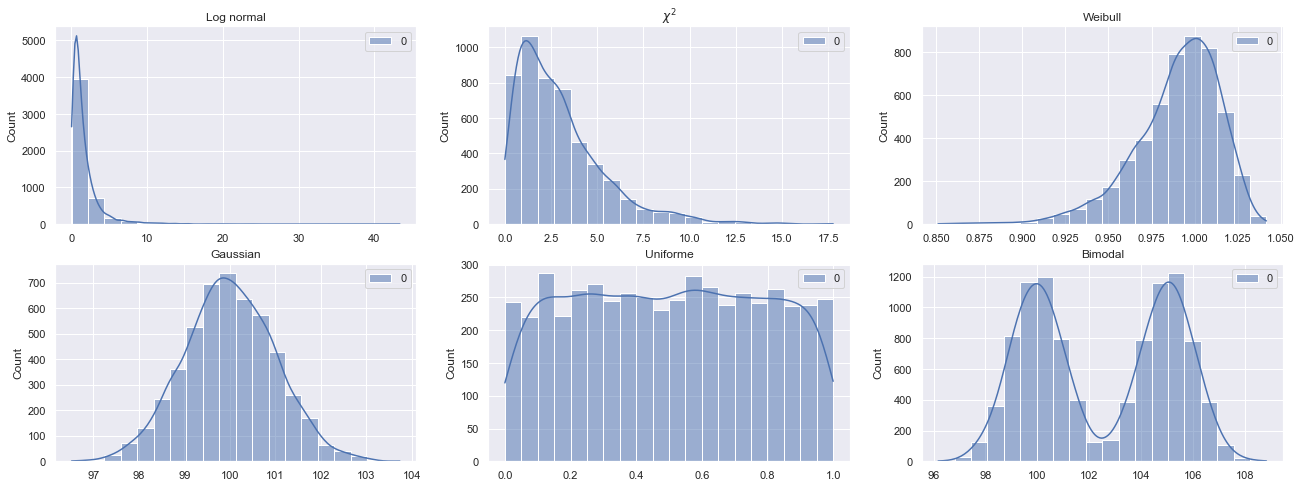

In [8]:
n_cols = 3
n_rows = int(len(distributions)/n_cols)
fig,axes = plt.subplots(n_rows,n_cols,figsize=(22,n_rows*4),squeeze=False)

for i,d in enumerate(distributions):
    iy= int(i/n_cols)
    ix= int(i%n_cols)
    sns.histplot(d[1], bins=20,ax=axes[iy][ix], kde=True).set_title(d[0])    

In [9]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import QuantileTransformer

rng = np.random.RandomState(304)
bc = PowerTransformer(method='box-cox')
yj = PowerTransformer(method='yeo-johnson')
# n_quantiles is set to the training set size rather than the default value
# to avoid a warning being raised by this example
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)

### 5.1 Transformación de Box-Cox


$$ 
y(\lambda)=  \left\{
\begin{array}{ll}
      \frac{y^\lambda-1}{\lambda} & si \lambda \ne 0; \\
      log(y) & si \lambda = 0 \\
\end{array} 
\right.
$$

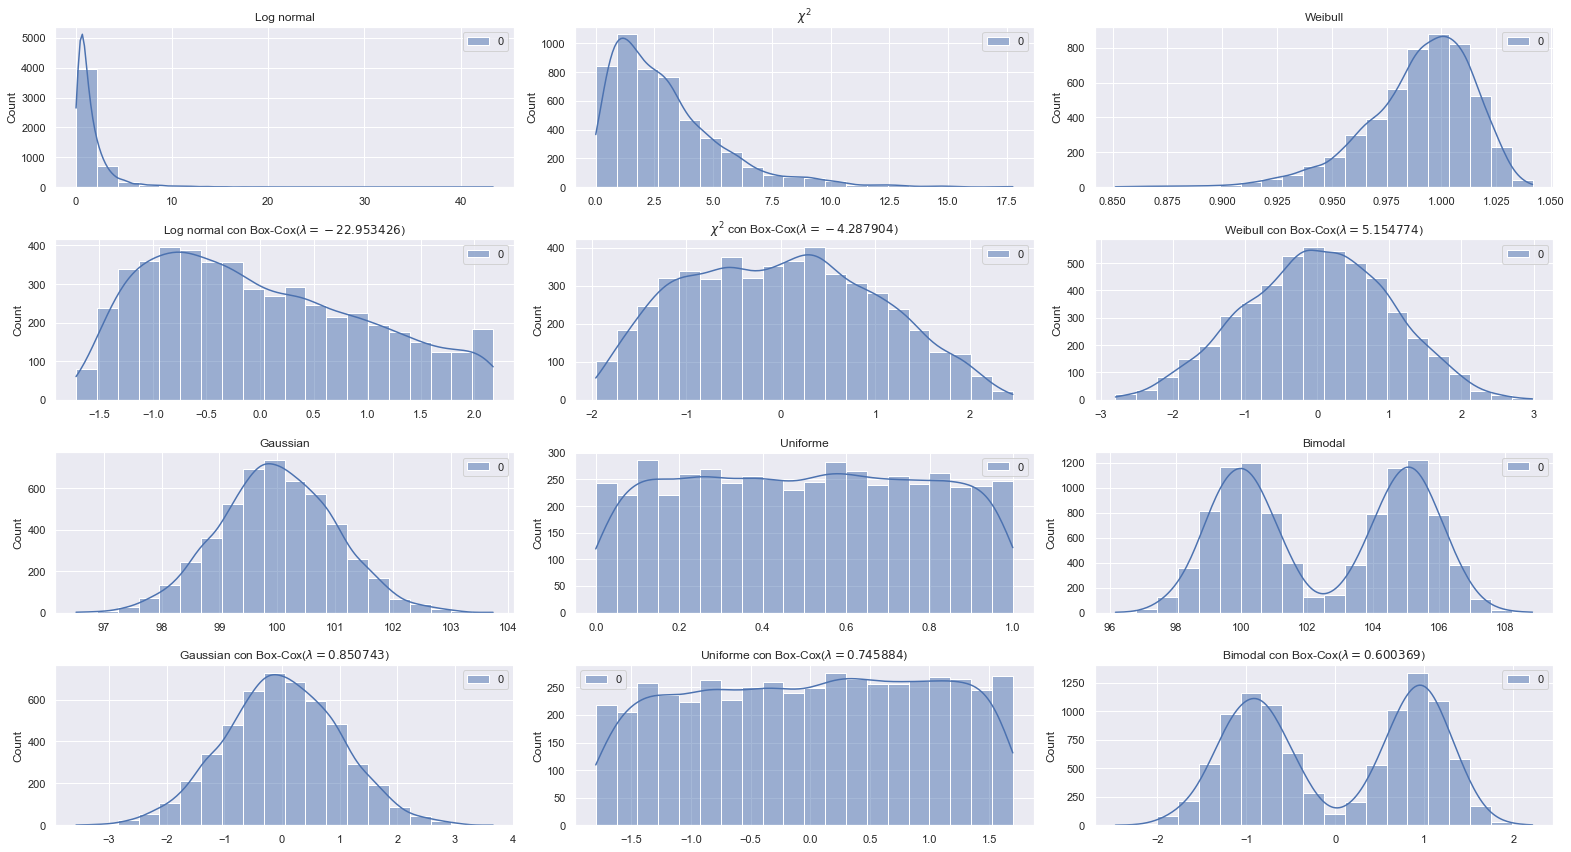

In [16]:
n_cols = 3
n_rows = int(len(distributions)/n_cols)
fig,axes = plt.subplots(2*n_rows,n_cols,figsize=(22,n_rows*6),squeeze=False)

for i,d in enumerate(distributions):
    iy= int(i/n_cols) * 2
    ix= int(i%n_cols)
    
    # Distribución original
    sns.histplot(d[1], bins=20,ax=axes[iy][ix], kde=True).set_title(d[0])   
    
    # Distribución transformada
    scaler = MinMaxScaler(feature_range=(1, 2)) # Box-Cox requiere que los valores de entrada sean positivos.
    power = PowerTransformer(method= 'box-cox' )
    pipeline = Pipeline(
        steps=[
           ( 's' , scaler),
           ( 'p' , power)
    ])
    X_transformed = pipeline.fit_transform(d[1])
    sns.histplot(X_transformed, bins=20, color='r',
                 ax=axes[iy+1][ix], kde=True).set_title("{} con Box-Cox($\lambda={:2f}$)".format(
                 d[0], pipeline.named_steps['p'].lambdas_[0]) )
fig.tight_layout()    

### 5.2 Transformación de Yeo-Johnson

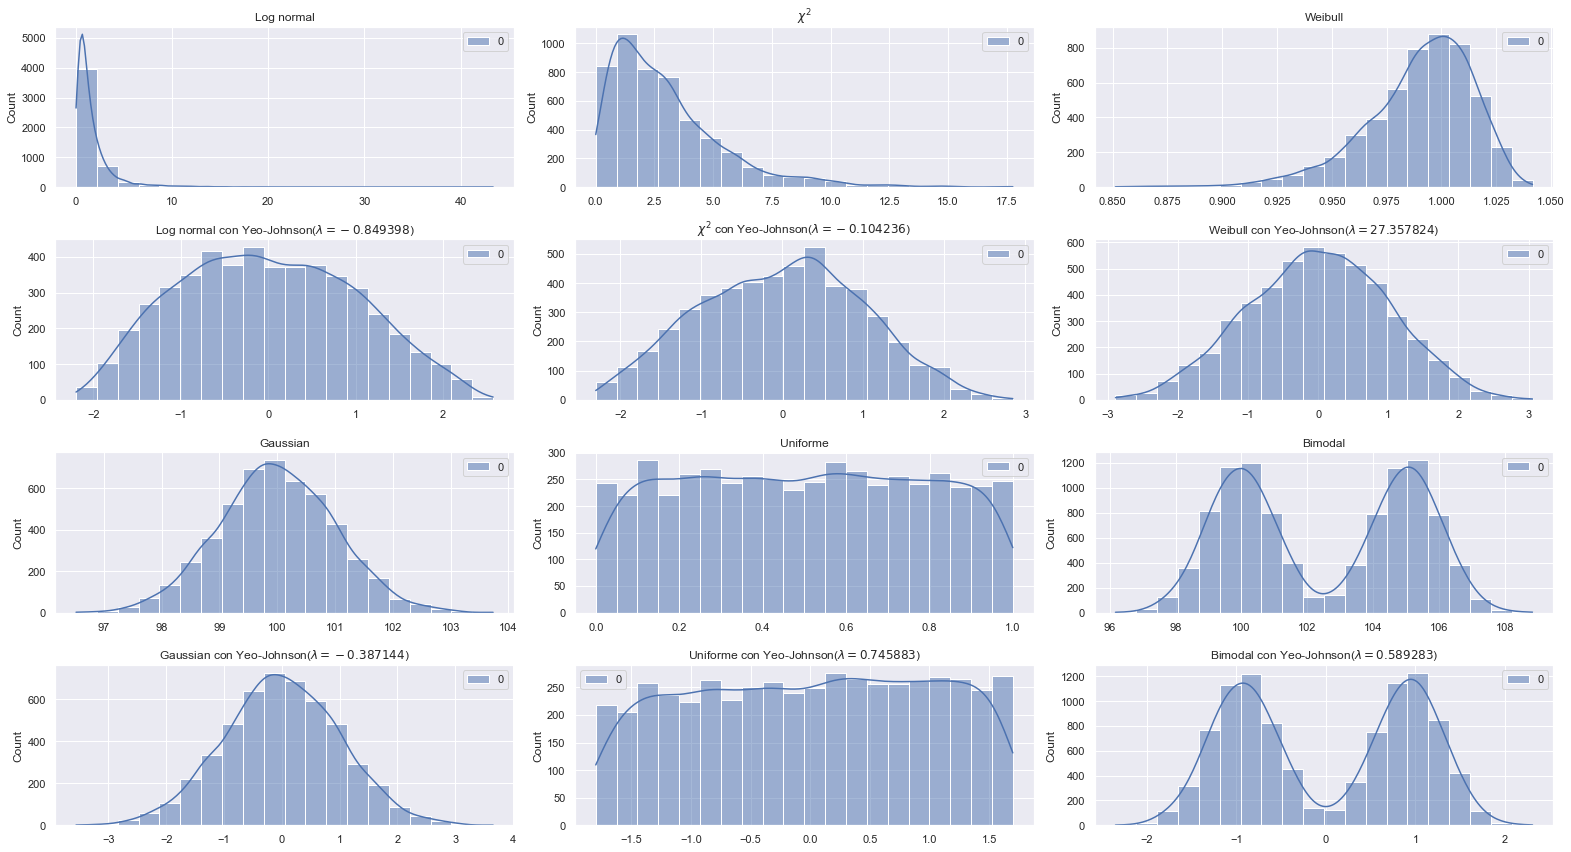

In [18]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline 

n_cols = 3
n_rows = int(len(distributions)/n_cols)
fig,axes = plt.subplots(2*n_rows,n_cols,figsize=(22,n_rows*6),squeeze=False)

for i,d in enumerate(distributions):
    iy= int(i/n_cols) * 2
    ix= int(i%n_cols)
    
    # Distribución original
    sns.histplot(d[1], bins=20,ax=axes[iy][ix], kde=True).set_title(d[0])   
    
    # Distribución transformada    
    power = PowerTransformer(method= 'yeo-johnson' )
    pipeline = Pipeline(
        steps=[
           ( 'p' , power)
    ])
    X_transformed = pipeline.fit_transform(d[1])
    sns.histplot(X_transformed, bins=20, color='r',
                 ax=axes[iy+1][ix], kde=True).set_title("{} con Yeo-Johnson($\lambda={:2f}$)".format(
                 d[0], pipeline.named_steps['p'].lambdas_[0]) )
fig.tight_layout()  

### 5.3 Quantiletransformer

¿Cuándo usar QuantileTransformer y cuándo Box-Cox/Yeo-Johnson?

> For comparison, we also add the output from QuantileTransformer. 
> It can force any arbitrary distribution into a gaussian, provided 
> that there are enough training samples (thousands). 
> Because it is a non-parametric method, it is harder to interpret than the parametric 
> ones (Box-Cox and Yeo-Johnson).

> On “small” datasets (less than a few hundred points), the quantile 
> transformer is prone to overfitting. The use of the power transform is then recommended.

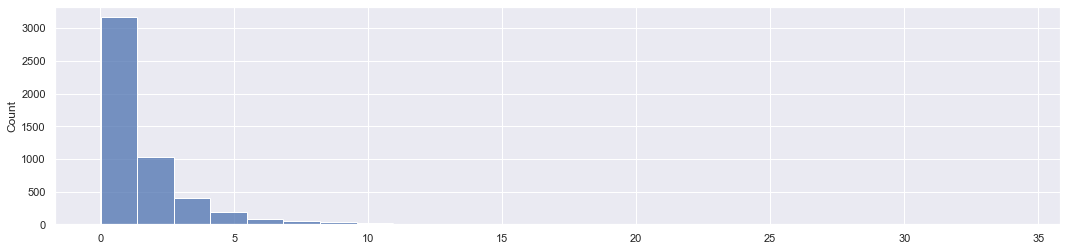

In [21]:
from sklearn.preprocessing import QuantileTransformer

fig,axes = plt.subplots(1,figsize=(18,4))
data = np.exp(np.random.randn(5000))
sns.histplot(data, bins=25, ax=axes);

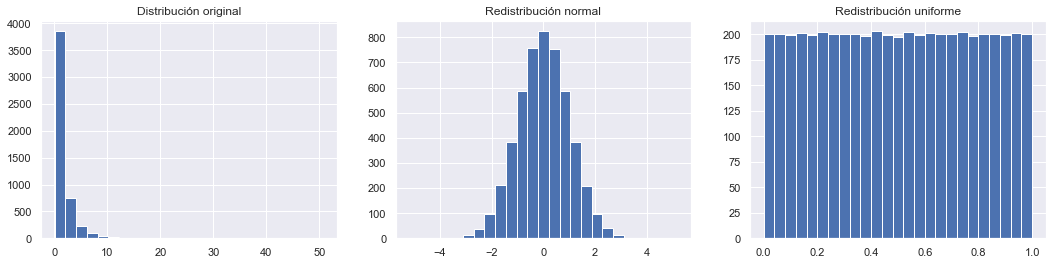

In [13]:
quantile_norm = QuantileTransformer(output_distribution= 'normal' )
quantile_unif = QuantileTransformer(output_distribution= 'uniform' )
data_tf_normal = quantile_norm.fit_transform(data.reshape(-1, 1))
data_tf_unif = quantile_unif.fit_transform(data.reshape(-1, 1))
fig,axes = plt.subplots(1,3,figsize=(18,4))
axes[0].hist(data, bins=25);axes[0].set_title("Distribución original")
axes[1].hist(data_tf_normal, bins=25);axes[1].set_title("Redistribución normal")
axes[2].hist(data_tf_unif, bins=25);axes[2].set_title("Redistribución uniforme");

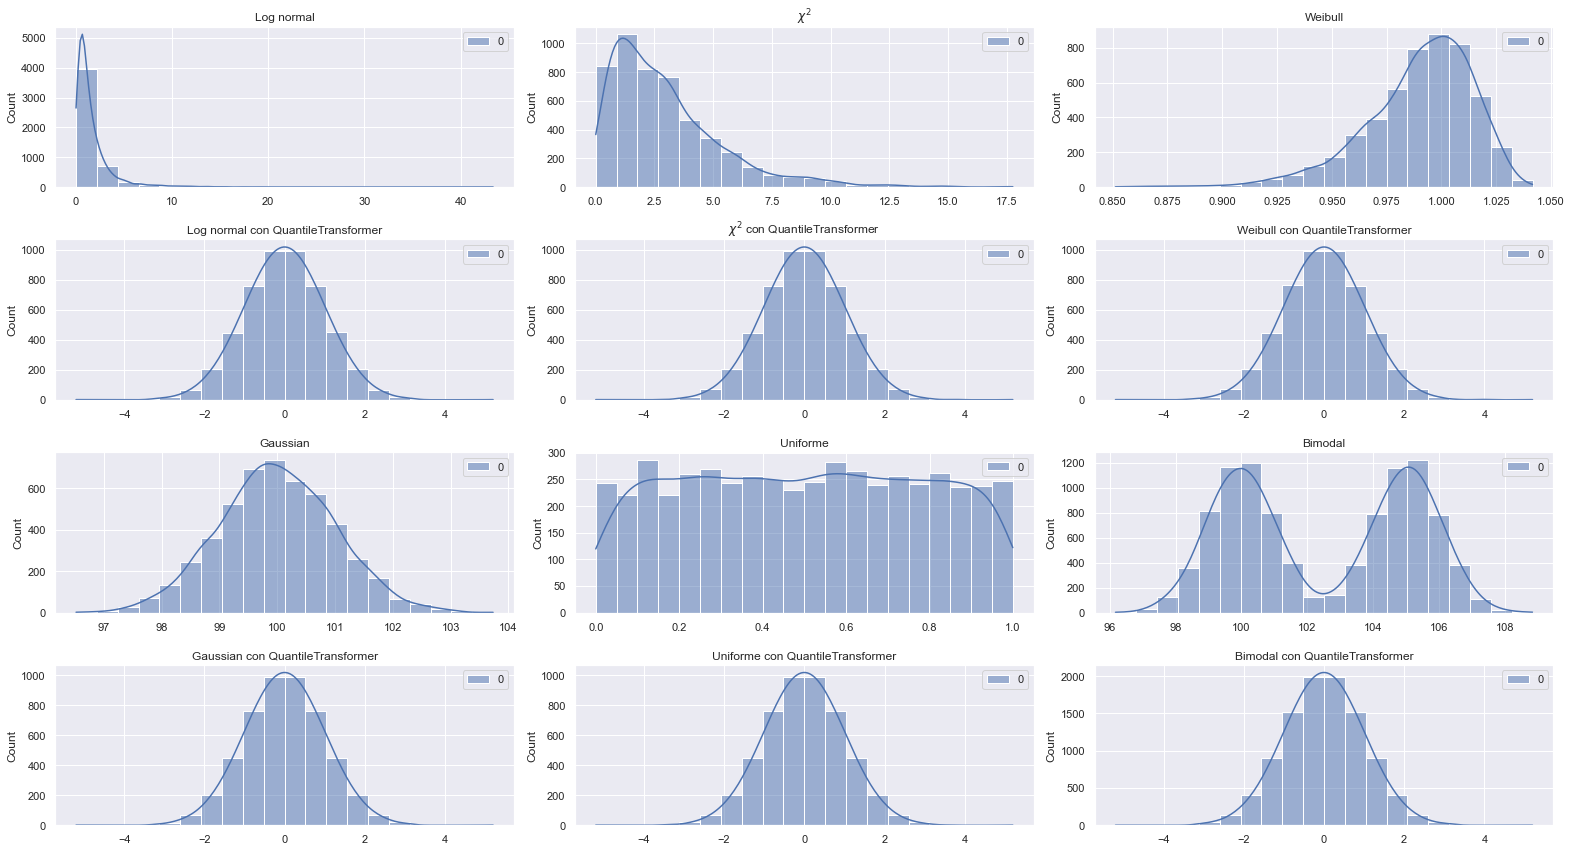

In [19]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline 

n_cols = 3
n_rows = int(len(distributions)/n_cols)
fig,axes = plt.subplots(2*n_rows,n_cols,figsize=(22,n_rows*6),squeeze=False)

for i,d in enumerate(distributions):
    iy= int(i/n_cols) * 2
    ix= int(i%n_cols)
    
    # Distribución original
    sns.histplot(d[1], bins=20,ax=axes[iy][ix], kde=True).set_title(d[0])   
    
    # Distribución transformada    
    pipeline = Pipeline(
        steps=[
           ( 'qt' , QuantileTransformer(output_distribution= 'normal'))
    ])
    X_transformed = pipeline.fit_transform(d[1])
    sns.histplot(X_transformed, bins=20, color='r',
                 ax=axes[iy+1][ix], kde=True).set_title("{} con QuantileTransformer".format(
                 d[0]) )
fig.tight_layout()  